In [0]:
# Call the corners
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import statsmodels as sm

sns.set()
%matplotlib inline

In [9]:
!pip install arch

In [0]:
from arch import arch_model

In [0]:
#Import the Data
import pandas_datareader.data as web
start = dt.datetime(1990, 1, 1)
end = dt.datetime(2019, 5, 31)
sp500 = web.get_data_yahoo('^GSPC', start=start, end=end)
vix_data = web.get_data_yahoo('^VIX', start=start, end=end)
vix_data = vix_data['Close'].round(2)

vix_ret = vix_data.pct_change().dropna()
sp_ret = 100*sp500['Adj Close'].pct_change().dropna()

In [12]:
# Split the train and test set by 70-30 rule NOTE TEMPORAL ISSUES SHOULD BE NULL BECAUSE OF SPLICED DATA
n = len(vix_ret)
n_train = int(n * 0.7)
n_test = n - n_train

X_train = vix_ret[:n_train]
X_test = vix_ret[n_train:]
split_date = X_test.index[0]
print('VIX')
print('No. train:', n_train)
print('No. test:', n_test)
print('Split date:', split_date)

VIX
No. train: 5187
No. test: 2223
Split date: 2010-08-02 00:00:00


In [13]:
# Split the train and test set GSPC by 70-30 rule NOTE TEMPORAL ABOVE
n = len(sp_ret)
n_train_g = int(n * 0.7)
n_test_g = n - n_train

X_train_g = sp_ret[:n_train]
X_test_g = sp_ret[n_train:]
split_date = X_test_g.index[0]
print('GSPC')
print('No. train:', n_train)
print('No. test:', n_test)
print('Split date:', split_date)

GSPC
No. train: 5187
No. test: 2223
Split date: 2010-08-02 00:00:00


In [29]:
%%time
# Use K-means clustering to define the spike in VIX
'''For now this is only the VIX'''
from sklearn.cluster import KMeans
n_clusters = 5

# Find the best kmeans with the minimum sum of square distances
num_seed = 100
ssd = np.zeros(num_seed)
for i in range(num_seed):
    if i % 20 == 0:
        print(i)
    kmeans = KMeans(n_clusters=n_clusters, random_state=i).fit(X_train.values.reshape(-1,1))
    ssd[i] = kmeans.inertia_
best_seed = ssd.argmin()
best_kmeans = KMeans(n_clusters=n_clusters, random_state=best_seed).fit(X_train.values.reshape(-1,1))

0
20
40
60
80
CPU times: user 15.8 s, sys: 12.1 ms, total: 15.8 s
Wall time: 15.8 s


In [15]:
# Find the boundaries of four state of VIX Returns
center = best_kmeans.cluster_centers_.copy()
print('center:', center)
center.sort(axis = 0)
boundary = (center[1:] + center[:-1])/2
print('boundary:', boundary)

center: [[ 0.02604758]
 [ 0.09425058]
 [-0.08371794]
 [ 0.25153359]
 [-0.02317968]]
boundary: [[-0.05344881]
 [ 0.00143395]
 [ 0.06014908]
 [ 0.17289208]]


In [0]:
train_label = best_kmeans.labels_
test_label = best_kmeans.predict(X_test.values.reshape(-1,1))

spike_label = best_kmeans.cluster_centers_.argmax()

# Label the spike as 1, other states as 0

# The first label should be removed because we can lose the first predicted vol returns
# when we use the predicted vol to calculate the predicted vol returns
y_train = train_label[1:].copy()
y_train[y_train != spike_label] = 0
y_train[y_train == spike_label] = 1


# The first label should be removed because we can lose the first predicted vol returns
# when we use the predicted vol to calculate the predicted vol returns

# The second label should also be removed because the model can only give us predicted vol
# without the first out-of-sample prediction
y_test = test_label[2:].copy()
y_test[y_test != spike_label] = 0
y_test[y_test == spike_label] = 1

In [17]:
# TTS Schema
print('Training set total:', len(y_train))
print('Training set 0:', len(y_train)-y_train.sum())
print('Training set 1:', y_train.sum())
print('Test set total:', len(y_test))
print('Test set 0:', len(y_test)-y_test.sum())
print('Test set 1:', y_test.sum())
print('Total 0:', len(y_train)-y_train.sum()+len(y_test)-y_test.sum())
print('Total 1:', y_train.sum()+y_test.sum())
print('Total:', len(y_train) + len(y_test))

Training set total: 5186
Training set 0: 5120
Training set 1: 66
Test set total: 2221
Test set 0: 2159
Test set 1: 62
Total 0: 7279
Total 1: 128
Total: 7407


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'VIX Returns')

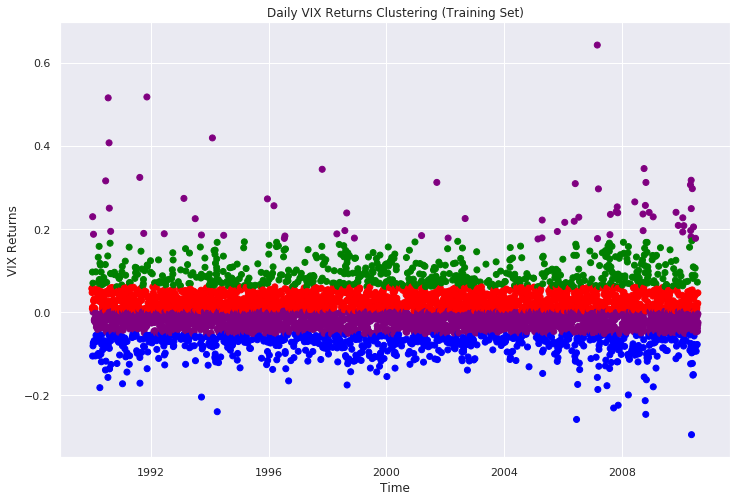

In [18]:
# Plot the clustering result in the training set
import matplotlib
colors = ['red','green','blue','purple']
plt.figure(figsize=(12,8))
plt.scatter(X_train.index, X_train.values, c=train_label, cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Daily VIX Returns Clustering (Training Set)')
plt.xlabel('Time')
plt.ylabel('VIX Returns')

Text(0, 0.5, 'VIX Returns')

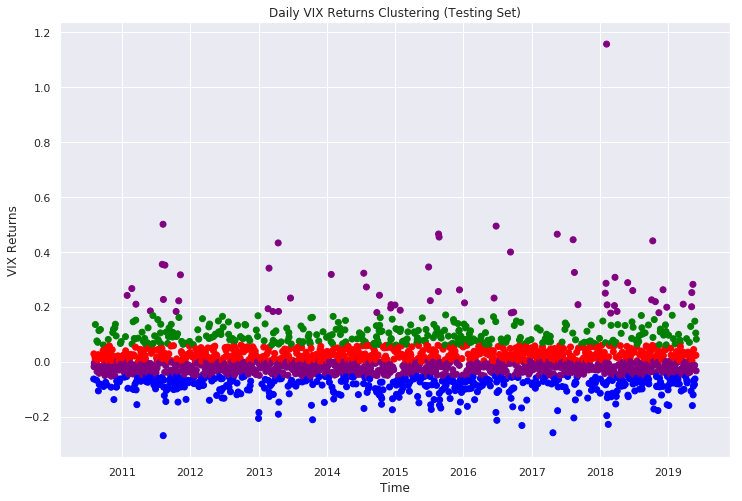

In [19]:
# Plot the clustering result in the testing set
colors = ['red','green','blue','purple']
plt.figure(figsize=(12,8))
plt.scatter(X_test.index, X_test.values, c=test_label, cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Daily VIX Returns Clustering (Testing Set)')
plt.xlabel('Time')
plt.ylabel('VIX Returns')

In [20]:
# Fit the GARCH(1,1) model to the sp500 returns
garch = arch_model(sp_ret, vol='GARCH', p=2, o=0, q=2, dist='Normal')
# garch = arch_model(sp_ret, vol='GARCH', p=1, o=0, q=1, dist='Normal') '''P = sigma squared of ARCH, q= MSE'''
res = garch.fit(last_obs=split_date, disp='off')

# GARCH model summary
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -7052.66
Distribution:                  Normal   AIC:                           14117.3
Method:            Maximum Likelihood   BIC:                           14156.6
                                        No. Observations:                 5187
Date:                Wed, Jun 26 2019   Df Residuals:                     5181
Time:                        00:09:54   Df Model:                            6
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0520  1.125e-02      4.624  3.765e-06 [2.

Text(0.5, 1.0, 'VIX vs GARCH Predicted Volatility')

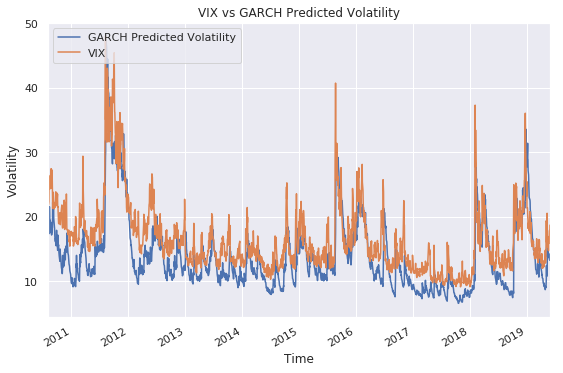

In [21]:
# Use GARCH model to predict conditional volatility of GSPC target against exogenous VIX
forecasts = res.forecast(horizon=1, start=split_date)
pred_vol = np.sqrt(forecasts.variance[split_date:].shift(1)['h.1'])

# # GARCH model parameters
# omega = res.params['omega']
# alpha = res.params['alpha[1]']
# beta = res.params['beta[1]']
# mu = res.params['mu']

# # Fill the first one-step forecast 
# last_con_vol = res.conditional_volatility[:split_date][-2]
# last_resi = res.resid[:split_date][-2]
# con_vol = np.sqrt(omega + alpha * last_resi**2 + beta * last_con_vol**2)
# pred_vol[split_date] = con_vol

# Annualize the GARCH predicted volatility
p_vol = pred_vol*np.sqrt(252)

# Plot the VIX and GARCH predicted volatility
p_vol.plot(figsize=(9,6))
vix_data[split_date:].plot(figsize=(9,6))
plt.ylabel('Volatility')
plt.xlabel('Time')
plt.legend(['GARCH Predicted Volatility', 'VIX'], loc='upper left')
plt.title('VIX vs GARCH Predicted Volatility')

In [22]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score

# predicted label in the testing set
pred_vix_ret = p_vol.pct_change().dropna()
pred_label = best_kmeans.predict(pred_vix_ret.values.reshape(-1,1))
pred_label[pred_label != spike_label] = 0
pred_label[pred_label == spike_label] = 1

# Compute the classification metrics
# y_test = true_label
# y_score = pred_vix_ret
# auc_pr = average_precision_score(y_test, pred_vix_ret)

# print('Average Precision Score:', auc_pr)
print('Recall:', recall_score(y_test, pred_label))
print('Precision:', precision_score(y_test, pred_label))
print(classification_report(y_test, pred_label))

Recall: 0.12903225806451613
Precision: 0.18181818181818182
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2159
           1       0.18      0.13      0.15        62

    accuracy                           0.96      2221
   macro avg       0.58      0.56      0.57      2221
weighted avg       0.95      0.96      0.96      2221



In [23]:
# Fit the EGARCH model to exponentiate the models (create breadth)
egarch = arch_model(sp_ret, p=2, o=0, q=2, vol='EGARCH')
res = egarch.fit(last_obs=split_date, disp='off')

# EGARCH model summary
print(res.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:              Adj Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                     EGARCH   Log-Likelihood:               -7059.17
Distribution:                  Normal   AIC:                           14130.3
Method:            Maximum Likelihood   BIC:                           14169.7
                                        No. Observations:                 5187
Date:                Wed, Jun 26 2019   Df Residuals:                     5181
Time:                        00:09:55   Df Model:                            6
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0474  1.126e-02      4.213  2.521e-05 [2.

Text(0.5, 1.0, 'VIX vs EGARCH Predicted Volatility')

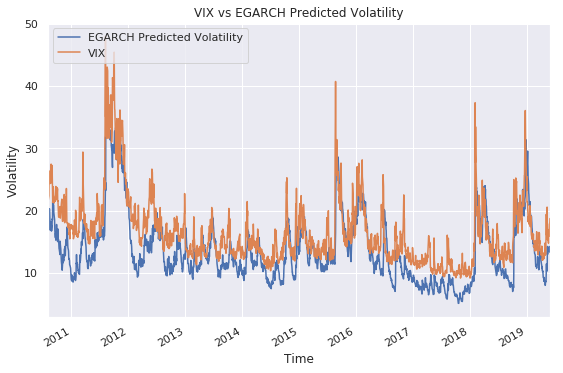

In [24]:
# Use EGARCH model to predict conditional volatility
forecasts = res.forecast(horizon=1, start=split_date, method='bootstrap')
pred_vol = np.sqrt(forecasts.variance[split_date:].shift(1)['h.1'])

# Annualize the EGARCH predicted volatility
p_vol = pred_vol*np.sqrt(252)

# Plot the VIX and GARCH predicted volatility
p_vol.plot(figsize=(9,6))
vix_data[split_date:].plot(figsize=(9,6))
plt.ylabel('Volatility')
plt.xlabel('Time')
plt.legend(['EGARCH Predicted Volatility', 'VIX'], loc='upper left')
plt.title('VIX vs EGARCH Predicted Volatility')

In [25]:
# predicted label in the testing set
pred_vix_ret = p_vol.pct_change().dropna()
pred_label = best_kmeans.predict(pred_vix_ret.values.reshape(-1,1))
pred_label[pred_label != spike_label] = 0
pred_label[pred_label == spike_label] = 1

# Compute the classification metrics
# y_test = true_label
# y_score = pred_vix_ret
# auc_pr = average_precision_score(y_test, pred_vix_ret)

# print('Average Precision Score:', auc_pr)
print('Recall:', recall_score(y_test, pred_label))
print('Precision:', precision_score(y_test, pred_label))
print(classification_report(y_test, pred_label))

Recall: 0.0967741935483871
Precision: 0.17647058823529413
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2159
           1       0.18      0.10      0.12        62

    accuracy                           0.96      2221
   macro avg       0.58      0.54      0.55      2221
weighted avg       0.95      0.96      0.96      2221



In [26]:
# AR(1) + GARCH(1,1)
from arch.univariate import ARX
from arch.univariate import GARCH
ar_garch = ARX(sp_ret, lags=[1])
ar_garch.volatility = GARCH(p=1, q=1)
res = ar_garch.fit(last_obs=split_date, disp='off')

# Model summary
print(res.summary())

                           AR - GARCH Model Results                           
Dep. Variable:              Adj Close   R-squared:                       0.001
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7058.89
Distribution:                  Normal   AIC:                           14127.8
Method:            Maximum Likelihood   BIC:                           14160.6
                                        No. Observations:                 5186
Date:                Wed, Jun 26 2019   Df Residuals:                     5181
Time:                        00:09:56   Df Model:                            5
                                   Mean Model                                   
                    coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------------------------
Const             0.0525  1.135e-02      4.624

Text(0.5, 1.0, 'VIX vs AR-GARCH Predicted Volatility')

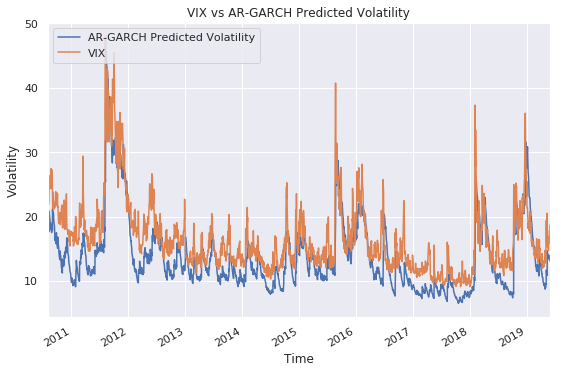

In [27]:
# Use the model to predict conditional volatility
forecasts = res.forecast(horizon=1, start=split_date)
pred_vol = np.sqrt(forecasts.variance[split_date:].shift(1)['h.1'])

# Annualize the predicted volatility
p_vol = pred_vol*np.sqrt(252)

# Plot the VIX and GARCH predicted volatility
p_vol.plot(figsize=(9,6))
vix_data[split_date:].plot(figsize=(9,6))
plt.ylabel('Volatility')
plt.xlabel('Time')
plt.legend(['AR-GARCH Predicted Volatility', 'VIX'], loc='upper left')
plt.title('VIX vs AR-GARCH Predicted Volatility')

In [28]:
# predicted label in the testing set
pred_vix_ret = p_vol.pct_change().dropna()
pred_label = best_kmeans.predict(pred_vix_ret.values.reshape(-1,1))
pred_label[pred_label != spike_label] = 0
pred_label[pred_label == spike_label] = 1

# Compute the classification metrics
# y_test = true_label
# y_score = pred_vix_ret
# auc_pr = average_precision_score(y_test, pred_vix_ret)

# print('Average Precision Score:', auc_pr)
print('Recall:', recall_score(y_test, pred_label))
print('Precision:', precision_score(y_test, pred_label))
print(classification_report(y_test, pred_label))

Recall: 0.04838709677419355
Precision: 0.061224489795918366
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2159
           1       0.06      0.05      0.05        62

    accuracy                           0.95      2221
   macro avg       0.52      0.51      0.51      2221
weighted avg       0.95      0.95      0.95      2221

